# Đồ Án Cuối Kì : Lập trình song song trên GPU
Nhóm sinh viên thực hiện : 

21424068 - Nguyễn Nguyên Văn

21424004 - Nguyễn Thành Đạt

21424061 - Nguyễn Minh Trọng Trí

## 1. Mô tả ứng dụng
- **Ứng dụng nhóm chọn**: Seam Carving
 - Seam Carving là một thuật toán để thay đổi kích thước hình ảnh.
 - Ưu điểm của thuật toán này là khi thay đổi kích thước ảnh thì các đối tượng quan trọng trong ảnh sẽ ít hoặc không bị biến dạng tùy vào độ lớn kích thước muốn thay đổi.
 - **Input**: một tấm ảnh (đồ án này: ảnh RGB).
 - **Output**: tấm ảnh được thay đổi kích thước mà không làm biến dạng các
đối tượng quan trọng (đồ án này: tấm ảnh được thu hẹp chiều rộng lại).
- **Ý nghĩa thực tế khi sử dụng**: 
 - Muốn có các phiên bản với các kích thước khác nhau của cùng một tấm ảnh để hiển thị trên các thiết bị khác nhau (máy tính, điện thoại, ...).
 - Có thể được ứng dụng cho các app có liên quan tới chỉnh sửa ảnh.
- **Ứng dụng này có cần tăng tốc hay không?**: Cần, ứng dụng này chạy chậm khi cài đặt tuần tự, điều này sẽ được thể hiện khi ở phần bên dưới.

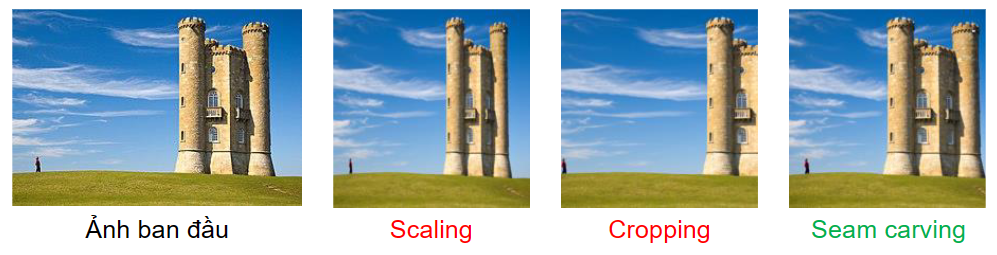

> Nguồn ảnh: Slide đồ án môn học

## 2. Các hàm hỗ trợ

- Xem phiên bản GPU hiện đang dùng

In [1]:
from numba import cuda
major, minor = cuda.get_current_device().compute_capability
print(f'GPU compute capability: {major}.{minor}')

GPU compute capability: 7.5


- Các hàm hỗ trợ cho việc hiển thị ảnh `pnm` và ma trận energy

In [2]:
from PIL import Image
import numpy as np

def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  print(f"Image size (width x height): {h}x{w}")
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  
  return Image.fromarray(pixels)

def show_matrix(matrix_file):
  m = np.loadtxt(matrix_file)
  m = m + m.min()
  m = m / m.max()
  m = m * 255
  m = m.astype(np.uint8)
  return Image.fromarray(m)

- Chương trình dùng để so sánh kết quả khi chạy trên Host và Device

In [3]:
!nvcc compare_result.cu -o compare_result

- Chúng ta sẽ dùng ảnh bên dưới để thực hiện thuật toán

Image size (width x height): 434x640


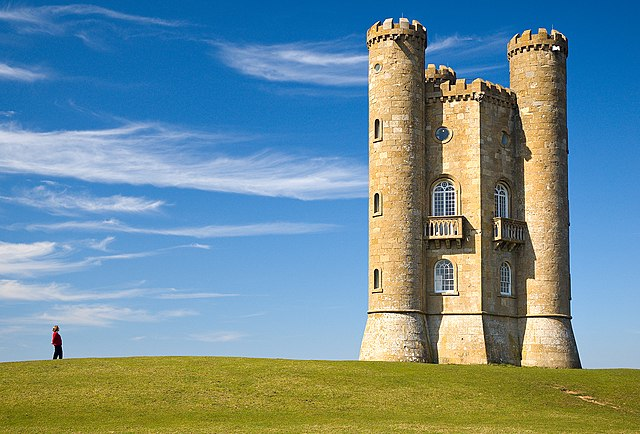

In [4]:
show_pnm("in.pnm")

## 3. Cài đặt tuần tự
#### 3.1. Thiết kế:
- **Ý tưởng thuật toán**: Chúng ta sẽ tìm seam ít quan trọng nhất và xóa seam này, lặp lại việc này cho đến khi đạt được chiều rộng mong muốn.
 - **Seam**: Một seam là một tập các pixel, mỗi dòng một pixel, pixel của dòng r & dòng r+1 được kết nối với nhau. </br> 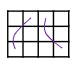
- **Các bước triển khai thuật toán**:
 - **Bước 1**: Tìm độ quan trọng của một pixel trong ảnh, hay nói cách khác là energy của mỗi pixel. Chúng ta sẽ dùng thuật toán edge detection để thực hiện điều này.
  >**Thuật toán Edge detection**: 
  > - Chuyển ảnh RGB sang ảnh grayscale
  > - Phát hiện cạnh theo chiều x (1): thực hiện convolution giữa ảnh grayscale với bộ lọc x-Sobel
  > 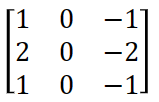
  >- Phát hiện cạnh theo chiều y (2): thực hiện convolution giữa ảnh grayscale với bộ lọc y-Sobel
  > 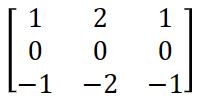
  > - Độ quan trọng của một pixel = |kết quả tương ứng của (1)| + |kết quả tương ứng của (2)|
  - **Bước 2**: Tính các đường seam ít quan trọng từ độ quan trọng của các pixel, chúng ta sẽ áp dụng thuật toán được mô tả trong slide môn học, nhưng thay vì đi từ dưới lên thì chúng ta sẽ đi từ trên xuống.
  > **Thuật toán**:
  > - Thuật toán sẽ bắt đầu từ row thứ 2 (bỏ qua row đầu tiên vì không cần tính cho row này) cho tới row cuối cùng
  > - Đối với từng col của mỗi row, chúng ta sẽ tìm col liền kề của row trước đó (row - 1) có tổng energy nhỏ nhất và cộng dồn với energy của vị trí đang xét.
  > - Lưu lại đường đi của seam vào mảng 2 chiều có kích thước theo kích thước ảnh hiện tại.
  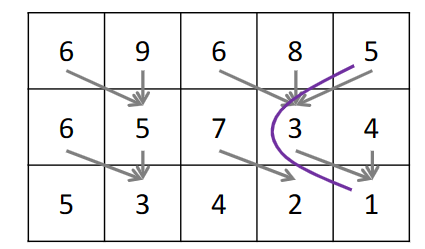
  - **Bước 3**: Tìm seam ít quan trọng nhất trong các seam vừa tính được.
  > **Thuật toán**:
  > - Duyệt row cuối cùng để tìm ra col có tổng energy nhỏ nhất
  > - Dựa vào mảng 2 chiều lưu trữ đường đi của seam và col bên trên, tìm ra seam ít quan trọng nhất
  - **Bước 4**: Thực hiện xóa seam vừa tìm được.
  > **Thuật toán**:
  > - Duyệt qua toàn mảng input, gán pixel vô mảng output, bỏ qua các pixel thuộc vị trí nằm trong seam vừa tìm được.
  - **Bước 5**: Thực hiện lại quy trình từ bước 1 - 4 cho đến khi đạt được độ rộng mong muốn.

#### 3.2. Đánh giá
- **Kịch bản thí nghiệm**: Chúng ta sẽ thay đổi kích thước ảnh với độ rộng giảm xuống 100

In [5]:
!nvcc seam_carving.cu -o seam_carving

In [6]:
!./seam_carving in.pnm 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Host: rgb2Gray() time: 1.685664 ms
Host: calcEnergy() time: 44.547039 ms
Host: minimumSeam() time: 5.425472 ms
Host: getMinimumSeam() time: 0.014336 ms
Host: removeSeam() time: 4.446176 ms
Total time: 79.204384 ms
Total time (100 cols): 5113.610352 ms


- Độ quan trọng của các pixel



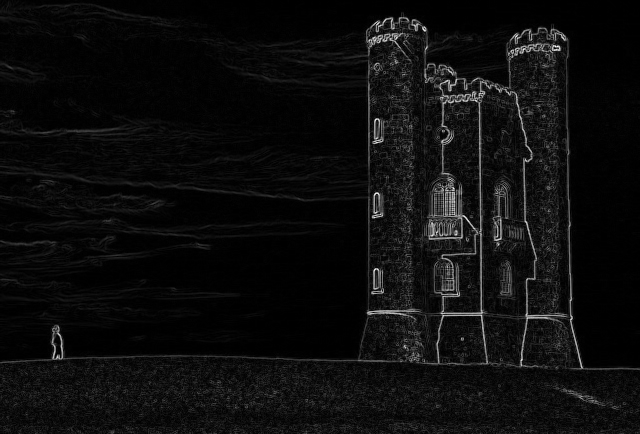

In [7]:
show_matrix("energy.txt")

- Seam ít độ quan trọng nhất, vì thuật toán tính seam là đi từ trên xuống dưới nên seam tìm được sẽ khác biệt so với ảnh minh họa trong slide đồ án

Image size (width x height): 434x640


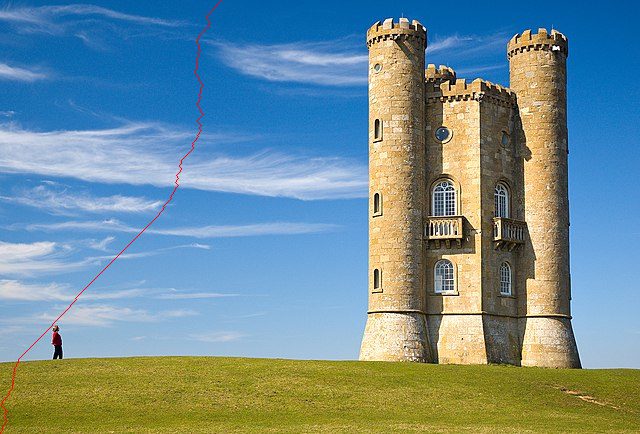

In [8]:
show_pnm("seam_host.pnm")

- Ảnh sau khi chiều rộng đã giảm xuống 100

Image size (width x height): 434x540


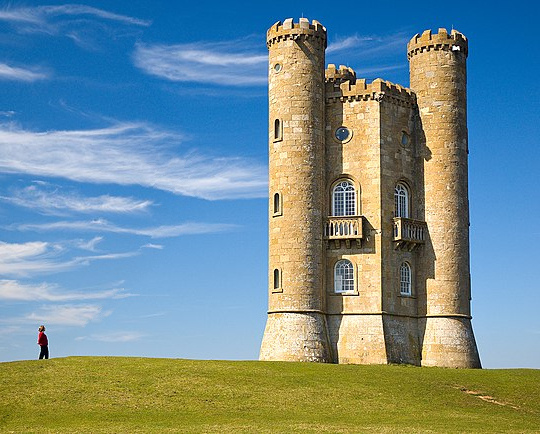

In [9]:
show_pnm("output_host.pnm")

- **Nhận xét**: 
 - Bức ảnh output chúng ta nhận được sau khi thực hiện thuật toán có vẻ đúng những gì mà chúng ta mong đợi, các đối tượng quan trọng trong bức ảnh không bị biến dạng mặc dù chiều rộng của bức ảnh đã được thay đổi. 
 - Thuật toán chạy khá chậm nếu thực hiện tuần tự (mất tầm 5000 - 6000ms).

## 4. Cài đặt song song
#### 4.1 Phân tích
- **Các bước sẽ được song song hóa**:
 - Chuyển đổi ảnh RGB sang ảnh grayscale (hàm `rgb2Gray`)
 - Tính độ quan trọng của từng pixel (hàm `calcEnergy`)
 - Xóa seam ít quan trọng nhất (hàm `removeSeam`)
- Chúng ta song song hóa các bước này đơn giản là vì các công việc trong hàm là độc lập với nhau, và sẽ cố gắng song song hóa hết mức có thể, thêm 1 phần nữa mà chúng ta có thể thấy rõ được là các bước này chạy cũng khá mất thời gian khi thực hiện tuần tự, đặc biệt là bước **Tính độ quan trọng của từng pixel** (chậm gấp nhiều lần so với các bước khác), nếu bức ảnh đủ lớn thì tốc độ thực thi sẽ rất là chậm.
- Đối với các bước còn lại không thực hiện song song hóa là vì các công việc trong hàm là phụ thuộc nhau (muốn tính row này cần kết quả của row trước), không có sự độc lập giữa các công việc nên khó có thể song song được.

#### 4.2. Thiết kế
- **Chuyển đổi ảnh RGB sang ảnh grayscale** : Mỗi thread sẽ đảm nhiệm việc thực hiện tính toán chuyển đổi từ RGB sang grayscale theo công thức cho một pixel.
- **Tính độ quan trọng của từng pixel** : Mỗi thread sẽ đảm nhiệm việc thực hiện convolution giữa một pixel của ảnh grayscale với bộ lọc x-Sobel và y-Sobel và cộng kết quả của cả 2.
- **Xóa seam ít quan trọng nhất** : Mỗi thread sẽ đảm nhiệm việc thực hiện gán một pixel từ input sang output, đối với các pixel thuộc vị trí nằm trong seam thì bỏ qua.
- **Tóm lại**: Về cơ bản, thuật toán bên trong sẽ giống như phiên bản tuần tự, nhưng thay vì duyệt tuần tự từng pixel bằng `for` thì ta dùng threads để quản lý từng pixel và cho nó chạy song song.

#### 4.2. Đánh giá

- **Kịch bản thí nghiệm**: Giống với phiên bản tuần tự, chúng ta sẽ thay đổi kích thước ảnh với độ rộng giảm xuống 100 và chạy với `blockSize` là `32x32`

In [10]:
!nvcc seam_carving_gpu.cu -o seam_carving_gpu

In [26]:
!./seam_carving_gpu in.pnm 100 32 32

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Kernel: rgb2GrayKernel() time: 0.035808 ms
Kernel: calcEnergyKernel() time: 0.049184 ms
Host: minimumSeam() time: 8.255840 ms
Host: getMinimumSeam() time: 0.031584 ms
Kernel: removeSeamKernel() time: 0.045984 ms
Total time: 9.514112 ms
Total time (100 cols): 587.126770 ms


- Ảnh output

Image size (width x height): 434x540


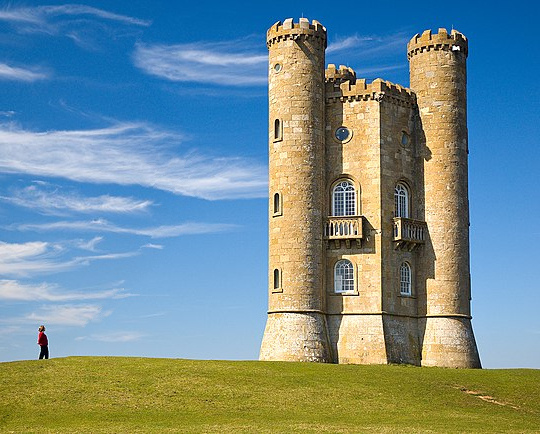

In [12]:
show_pnm("output_gpu.pnm")

- So sánh sai số giữa kết quả của Host và Device

In [13]:
!./compare_result output_host.pnm output_gpu.pnm

Error: 0.000000


- **Nhận xét**: Như đã thấy, kết quả của 2 bên là như nhau và tốc độ cũng nhanh hơn rất nhiều (500 - 600 ms) so với host

## 5. Cài đặt song song
#### 5.1. Tối ưu hóa lần 1
##### 5.1.1.  Phân tích
- **Các bước sẽ được tối ưu hóa**:
 - Tính độ quan trọng của từng pixel
- Có 2 lý do để tối ưu hóa các bước ở trên:
 - Nhóm đã test thử trên các hàm kernel và chỉ có hàm kernel của bước **Tính độ quan trọng của từng pixel** là có sự tối ưu về tốc độ.
 - Đi sâu hơn vô thuật toán thì đối với các hàm kernel khác, lượt truy xuất DRAM trước và sau khi dùng SMEM là như nhau, vì SMEM cũng cần phải truy xuất DRAM để đổ dữ liệu vào, còn hàm kernel của bước **Tính độ quan trọng của từng pixel** thì lượt truy xuất DRAM trước và sau khi dùng SMEM là khác nhau, dùng SMEM thì việc truy xuất DRAM được giảm đi rất nhiều so với không dùng (sự khác biệt như vậy đơn giản là do thuật toán), cộng thêm việc dùng CMEM càng làm cho tốc độ được tối ưu hóa thêm.

##### 5.1.2. Thiết kế
Thuật toán về mặt cơ bản là không thay đổi, nhưng thay vì truy xuất dữ liệu thông qua DRAM thì chuyển qua dùng SMEM và CMEM để truy xuất, chỉ cần bổ sung thêm 1 bước là đổ dữ liệu từ DRAM vô SMEM, CMEM.

###### 5.1.3. Đánh giá
- **Kịch bản thí nghiệm**: Chúng ta sẽ thay đổi kích thước ảnh với độ rộng giảm xuống 100 và chạy với `blockSize` là `32x32`

In [14]:
!nvcc seam_carving_gpu_v2.cu -o seam_carving_gpu_v2

In [15]:
!./seam_carving_gpu_v2 in.pnm 100 32 32

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Kernel: rgb2GrayKernel() time: 0.038400 ms
Kernel: calcEnergyKernel() time: 0.047648 ms
Host: minimumSeam() time: 5.437472 ms
Host: getMinimumSeam() time: 0.034272 ms
Kernel: removeSeamKernel() time: 0.040928 ms
Total time: 6.304000 ms
Total time (100 cols): 524.982117 ms


- Ảnh output

Image size (width x height): 434x540


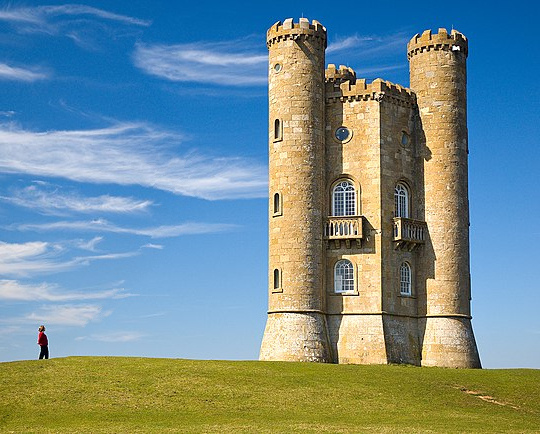

In [16]:
show_pnm("output_gpu_v2.pnm")

- So sánh sai số giữa kết quả của Host và phiên bản tối ưu lần 1


In [17]:
!./compare_result output_host.pnm output_gpu_v2.pnm

Error: 0.000000


- **Nhận xét**: Nhìn chung thì kết quả sau khi tối ưu lần 1 thì có lúc nhanh, có lúc chậm hơn so với không tối ưu, nhưng nếu nhìn kỹ hơn thì có thể thấy thời gian thực thi hàm kernel của bước **Tính độ quan trọng của từng pixel** có sự giảm xuống nhưng không nhiều, cộng thêm thời gian thực thi của toàn bộ chương trình phụ thuộc vào thời gian của các hàm khác chứ không riêng hàm được tối ưu, nên nhìn chung thì chương trình cũng không được cải thiện gì mấy.

#### 5.2. Tối ưu hóa lần 2
##### 5.2.1.  Phân tích
- **Các bước sẽ được tối ưu**:
 - Tính các đường seam (hàm `mininumSeam`)
- Như đã nói ở trên, hàm tính các đường seam không thể song song hóa hoàn toàn vì các công việc phụ thuộc lẫn nhau (muốn tính row này thì cần kết quả của row trước đó), nhưng sau khi nhóm xem lại thuật toán thì nó chỉ có sự phụ thuộc giữa các row, còn giữa các col của mỗi row thì lại độc lập với nhau. Nhóm sẽ dựa vào điểm này để tối ưu.
- Hàm còn lại (hàm `getMinimumSeam`) thì không thể song song hóa được, không giống với hàm bên trên, hàm này chỉ có 1 vòng lặp duy nhất (row), và các công việc phụ thuộc lẫn nhau, quan trọng hơn là thời gian thực thi của hàm này cũng ngang ngang với các hàm kernel nên có thể bỏ qua.

##### 5.2.2. Thiết kế
- Đối với hàm này, nhóm sẽ thực hiện nửa tuần tự, nửa song song hóa, chúng ta cứ duyệt tuần tự các row như bình thường ở phía CPU bằng `for`, mỗi lần duyệt qua 1 row, chúng ta sẽ gọi hàm kernel một lần để xử lý các col của row đang xét. Về mặt cơ bản thì thuật toán của hàm kernel không khác so với hàm tuần tự, nhưng mà thay vì duyệt qua 2 vòng lặp, thì chúng ta chỉ duyệt 1 vòng lặp (row) và song song hóa vòng lặp thứ 2 (col).
- Hàm kernel sử dụng thêm SMEM để thêm một bước tối ưu hóa.

##### 5.2.3 Đánh giá
- **Kịch bản thí nghiệm**: Chúng ta sẽ thay đổi kích thước ảnh với độ rộng giảm xuống 100 và chạy với `blockSize` là `32x32`

In [18]:
!nvcc seam_carving_gpu_v3.cu -o seam_carving_gpu_v3

In [19]:
!./seam_carving_gpu_v3 in.pnm 100 32 32

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Kernel: rgb2GrayKernel() time: 0.036480 ms
Kernel: calcEnergyKernel() time: 0.046048 ms
Kernel: minimumSeamKernel() time: 1.831648 ms
Host: getMinimumSeam() time: 0.056000 ms
Kernel: removeSeamKernel() time: 0.036832 ms
Total time: 3.553120 ms
Total time (100 cols): 244.128571 ms


- Ảnh output

Image size (width x height): 434x540


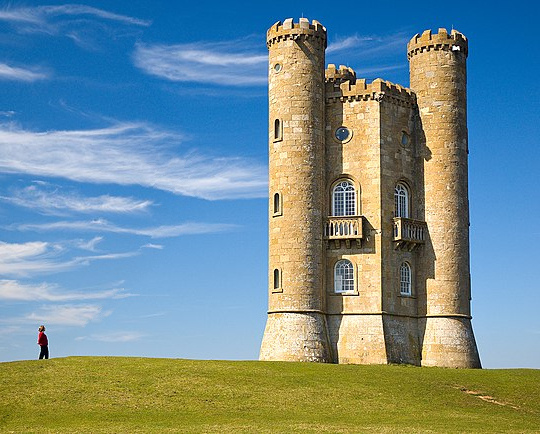

In [20]:
show_pnm("output_gpu_v3.pnm")

- So sánh kết quả của Host và phiên bản tối ưu lần 2

In [21]:
!./compare_result output_host.pnm output_gpu_v3.pnm

Error: 0.000000


- **Nhận xét**: Dựa vào sai số thì kết quả của phiên bản này vẫn đúng và tốc độ thực thi cũng nhanh hơn rất nhiều so với lần 1 (250-260ms)

#### 5.3. Tối ưu hóa lần 3
##### 5.3.1.  Phân tích
Ở phiên bản tối ưu này, nhóm sẽ không tập trung vào việc tối ưu thuật toán, như đã thấy còn 1 hàm chưa thể song song hóa (`getMinimumSeam`), và hàm này nằm giữa 2 hàm Kernel, điều này có nghĩa là hàm này sẽ chạy trên Host, và để có thể chạy trên Host, phải mất thêm 1 bước trung gian là đổ dữ liệu qua lại giữa Host và Device, mặc dù tốc độ thực thi của hàm này cũng khá nhanh, nhưng phải mất thêm công đoạn đổ dữ liệu qua lại, nên vô tính khiến cho chương trình mất thêm thời gian để xử lý, và với lượng dữ liệu đủ lớn thì việc đổ dữ liệu sẽ mất thời gian rất nhiều so với việc chạy hàm kernel (lab 2 có thể thấy rõ điều đó). Chính vì vậy, ở phiên bản này sẽ tập trung tối ưu việc chuyển đổi dữ liệu giữa Host và Device.

##### 5.3.2 Thiết kế
- Theo những gì nhóm tìm hiểu, thì Host sẽ mặc định cấp phát **pageable memory**, GPU không thể truy xuất dữ liệu trực tiếp từ bộ nhớ này được, vì vậy để chuyển đổi dữ liệu, CUDA driver bắt buộc phải cấp phát một bộ nhớ tạm, hay còn gọi là **pinned memory**, sau đó copy dữ liệu của host từ pageable sang pinned, cuối cùng là mới chuyển dữ liệu từ pinned sang bộ nhớ của GPU.</br>
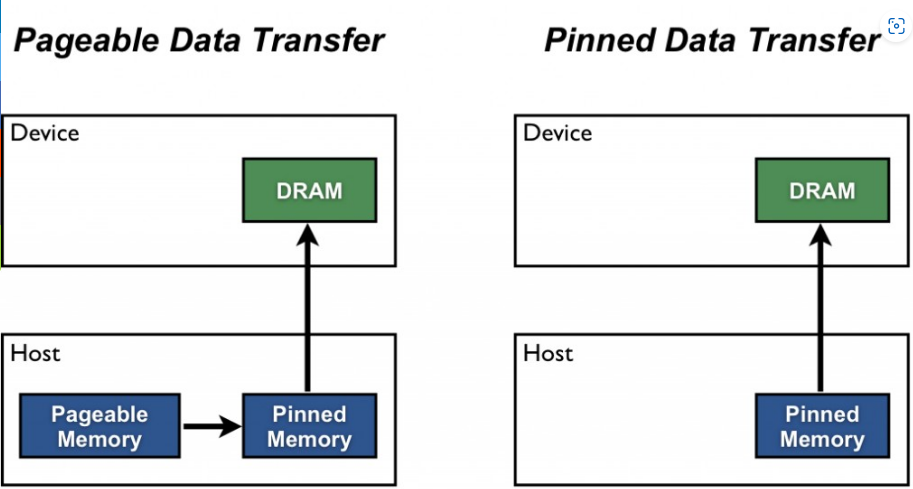
- Vì vậy, ở phiên bản này, thay vì cấp phát mặc định **pageable memory** ở Host thì sẽ cấp phát trực tiếp **pinned memory** bằng hàm `cudaMallocHost()`, và giải phóng bằng hàm `cudaFreeHost()`

##### 5.3.3. Đánh giá
- **Kịch bản thí nghiệm**: Chúng ta sẽ thay đổi kích thước ảnh với độ rộng giảm xuống 100 và chạy với `blockSize` là `32x32`

In [22]:
!nvcc seam_carving_gpu_v4.cu -o seam_carving_gpu_v4

In [23]:
!./seam_carving_gpu_v4 in.pnm 100 32 32

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Kernel: rgb2GrayKernel() time: 0.037536 ms
Kernel: calcEnergyKernel() time: 0.046560 ms
Kernel: minimumSeamKernel() time: 1.791776 ms
Host: getMinimumSeam() time: 0.026880 ms
Kernel: removeSeamKernel() time: 0.034592 ms
Total time: 2.286944 ms
Pageable transfer data time: 1.746240 ms
Pinned transfer data time: 0.215552 ms
Total time (100 cols): 197.046524 ms


- Ảnh output

Image size (width x height): 434x540


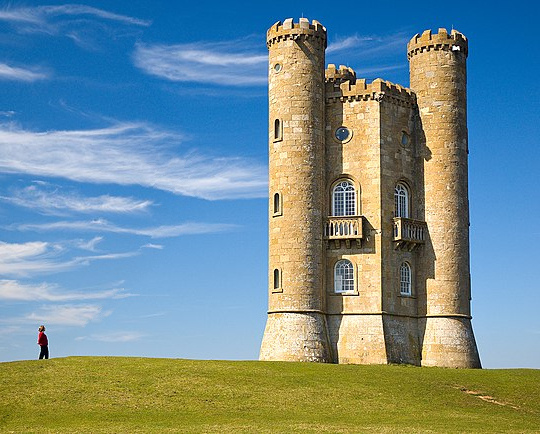

In [24]:
show_pnm("output_gpu_v4.pnm")

- So sánh kết quả của Host và phiên bản tối ưu lần 3

In [25]:
!./compare_result output_host.pnm output_gpu_v4.pnm

Error: 0.000000


**Nhận xét**: Kết quả vẫn đúng và thời gian thực thi cũng được cải thiện rất nhiều so với phiên bản trước đó.

## 6. Nhìn lại quá trình làm đồ án
- **Thuận lợi**: Có nhiều nguồn tham khảo trên internet về thuật toán Seam Carving
- **Khó khăn**:
 - Ngoại trừ một số cách tối ưu trong slide môn học thì việc nghĩ ra một phiên bản tối ưu cũng là điều khá khó khăn
 - Đôi khi gặp lỗi ở phía GPU thì khá khó khăn trong việc gỡ lỗi, ít nhất là nhóm chưa quen với việc gỡ lỗi song song hóa
- **Những gì đã học được**:
 - Biết thêm về thuật toán Seam Carving
 - Hiểu rõ hơn về cách song song hóa và cách tối ưu nó
 - Biết rõ hơn về việc truy xuất dữ liệu
- **Nếu có thêm thời gian**:
 - Có thể thực hiện rút gọn kích thước theo chiều dọc

## 7. Nguồn tham khảo
- Slide môn học và đồ án môn học
- [Seam Carving Algorithm](https://vnoi.info/wiki/cs/imageprocessing/Seam-Carving.md)
- [Implementing Seam Carving with Python](https://karthikkaranth.me/blog/implementing-seam-carving-with-python/)
- [Github GPU Python](https://github.com/tuancamtbtx/gpu-python)